In [1]:
# Cell 1: Import Libraries and Install Requirements
# Install required packages
!pip install azure-storage-blob

# Import all the tools we need
import requests
import pandas as pd
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import json
import time

# Check if imports worked
print("All libraries imported successfully!")
print(f"Current time: {datetime.now()}")

All libraries imported successfully!
Current time: 2025-07-30 10:44:56.712707


In [2]:
# Target hotels
hotels = [
    {"name": "Pendry Manhattan West", "id": "68272643"},
    {"name": "The Mercer", "id": "118588"},
    {"name": "Hotel Barriere Fouquets", "id": "88270883"},
    {"name": "Casa Cipriani", "id": "60020170"},
    {"name": "The Mark", "id": "19712"},
    {"name": "Baccarat Hotel and Residences", "id": "9759603"}
]

# Display hotels
for hotel in hotels:
    print(f"{hotel['name']} (ID: {hotel['id']})")

Pendry Manhattan West (ID: 68272643)
The Mercer (ID: 118588)
Hotel Barriere Fouquets (ID: 88270883)
Casa Cipriani (ID: 60020170)
The Mark (ID: 19712)
Baccarat Hotel and Residences (ID: 9759603)


In [3]:
# Add this after Cell 2 to verify hotels
print(f"\nVerifying {len(hotels)} hotels:")
for i, hotel in enumerate(hotels):
    print(f"{i+1}. {hotel['name']} (ID: {hotel['id']})")
print(f"\nTotal unique hotel IDs: {len(set(h['id'] for h in hotels))}")


Verifying 6 hotels:
1. Pendry Manhattan West (ID: 68272643)
2. The Mercer (ID: 118588)
3. Hotel Barriere Fouquets (ID: 88270883)
4. Casa Cipriani (ID: 60020170)
5. The Mark (ID: 19712)
6. Baccarat Hotel and Residences (ID: 9759603)

Total unique hotel IDs: 6


In [4]:
# Cell 3: Create config file (only if it doesn't exist)
import os

if os.path.exists('hip_config.txt'):
    print("✓ Config file already exists! Not overwriting.")
    print("  To add/change your token, edit 'hip_config.txt' directly.")
else:
    config_content = """# Configuration for HIP
CRAWLBASE_TOKEN=your_token_here
"""
    with open('hip_config.txt', 'w') as f:
        f.write(config_content)
    
    print("✅ Config file created!")
    print("  Now edit 'hip_config.txt' and add your Crawlbase JavaScript token")

✓ Config file already exists! Not overwriting.
  To add/change your token, edit 'hip_config.txt' directly.


In [5]:
# Function to read your token safely
def get_crawlbase_token():
    """Read token from config file"""
    try:
        with open('hip_config.txt', 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('CRAWLBASE_TOKEN='):
                    token = line.split('=')[1].strip()
                    return token
        print("Token not found in config file!")
        return None
    except FileNotFoundError:
        print("Config file not found! Run cell 3 first.")
        return None

# Test loading token
token = get_crawlbase_token()
if token and token != 'your_token_here':
    print("✓ Token loaded successfully!")
    print(f"Token starts with: {token[:10]}...")
else:
    print("✗ Please add your token to hip_config.txt")

✓ Token loaded successfully!
Token starts with: 8i_FkaiD6T...


In [6]:
# Let's build a URL for one test case
hotel = hotels[0]  # Pendry Manhattan West
check_in = datetime.now() + timedelta(days=7)  # 7 days from now
check_out = check_in + timedelta(days=1)  # Next day

# Format dates
check_in_str = check_in.strftime('%Y-%m-%d')
check_out_str = check_out.strftime('%Y-%m-%d')

# Build URL
base_url = f"https://www.expedia.com/New-York-Hotels-{hotel['name'].replace(' ', '-')}"
full_url = f"{base_url}.h{hotel['id']}.Hotel-Information?chkin={check_in_str}&chkout={check_out_str}"

print(f"Hotel: {hotel['name']}")
print(f"Check-in: {check_in_str}")
print(f"Check-out: {check_out_str}")
print(f"\nURL: {full_url[:100]}...")  # Show first 100 characters

Hotel: Pendry Manhattan West
Check-in: 2025-08-06
Check-out: 2025-08-07

URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-Information?chkin=2025...


In [7]:
# Cell 6: Test Crawlbase Connection
def fetch_with_crawlbase(url, token):
    """Fetch a URL using Crawlbase API"""
    
    # Crawlbase API endpoint - note the specific format
    crawlbase_api = "https://api.crawlbase.com/"
    
    params = {
        'token': token,
        'url': url,
        'ajax_wait': 'true',  # Wait for JavaScript to load
        'page_wait': '5000'   # Wait 5 seconds for page to fully load
    }
    
    try:
        print(f"Fetching URL via Crawlbase...")
        print(f"Target URL: {url[:80]}...")  # Show first 80 chars
        
        response = requests.get(crawlbase_api, params=params)
        
        print(f"Response status: {response.status_code}")
        
        if response.status_code == 200:
            print("✓ Success! Page fetched.")
            return response.text
        else:
            print(f"✗ Error: Status code {response.status_code}")
            print(f"Response: {response.text[:200]}")  # Show error message
            return None
            
    except Exception as e:
        print(f"✗ Error: {e}")
        return None

# Test with our URL
token = get_crawlbase_token()  # Make sure we have the latest token
html = fetch_with_crawlbase(full_url, token)

if html:
    print(f"\nReceived HTML: {len(html)} characters")
    # Show a small preview
    print("\nFirst 500 characters:")
    print(html[:500])
else:
    print("\nNo HTML received. Check your token and try again.")

Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Response status: 200
✓ Success! Page fetched.

Received HTML: 1264208 characters

First 500 characters:
<html data-language="en_US" dir="ltr" lang="en"><head><title>Pendry Manhattan West</title><link rel="canonical" href="https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-Information"><link rel="preconnect" href="https://images.trvl-media.com/"><link rel="preconnect" href="https://maps.googleapis.com/"><link rel="preload" href="https://c.travel-assets.com/shopping-pwa/bernie.64c9ac0f82e08a5c53aa.js" as="script"><link rel="preload" href="https://c.travel-assets.com/shoppi


In [8]:
# Cell 7: Parse HTML to Find Price (with debugging)
print("Starting Cell 7...")

# Check if we have HTML
if 'html' not in globals():
    print("❌ 'html' variable not found. Please run Cell 6 first.")
elif html is None:
    print("❌ 'html' is None. Cell 6 didn't fetch the page successfully.")
elif len(html) == 0:
    print("❌ 'html' is empty.")
else:
    print(f"✓ HTML found: {len(html)} characters")
    
    soup = BeautifulSoup(html, 'html.parser')
    print("✓ HTML parsed with BeautifulSoup")
    
    # Find all text containing '$'
    price_texts = soup.find_all(text=lambda text: '$' in text if text else False)
    
    print(f"\nFound {len(price_texts)} elements with '$'")
    
    if len(price_texts) == 0:
        print("No dollar signs found in the HTML")
        # Let's try a different approach - look for common price classes
        price_elements = soup.find_all(['span', 'div'], class_=lambda x: x and 'price' in x.lower() if isinstance(x, str) else False)
        print(f"\nFound {len(price_elements)} elements with 'price' in class name")
    else:
        print("\nFirst 10 price-like texts:")
        count = 0
        for i, text in enumerate(price_texts):
            clean_text = text.strip()
            if clean_text and len(clean_text) < 50:
                if '$' in clean_text and any(char.isdigit() for char in clean_text):
                    count += 1
                    print(f"{count}: {clean_text}")
                    if count >= 10:
                        break
        
        if count == 0:
            print("No price-like text found (text with $ and numbers)")

print("\nCell 7 complete.")

Starting Cell 7...
✓ HTML found: 1264208 characters
✓ HTML parsed with BeautifulSoup

Found 96 elements with '$'

First 10 price-like texts:
1: + $0
2: + $46
3: $945 nightly
4: The current price is $1,088 total
5: $1,088 total
6: + $0
7: + $46
8: $945 nightly
9: The current price is $1,088 total
10: $1,088 total

Cell 7 complete.


C:\Users\bjlce\AppData\Local\Temp\ipykernel_36092\1193029050.py:18: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  price_texts = soup.find_all(text=lambda text: '$' in text if text else False)


In [9]:
# Cell 8: Extract Lowest Fully Refundable Rate
def extract_price_from_html(html):
    """
    Extract the lowest FULLY REFUNDABLE rate from Expedia HTML
    """
    soup = BeautifulSoup(html, 'html.parser')
    
    print("🔍 Searching for 'Fully refundable' rates...\n")
    
    # Find all text containing "Fully refundable"
    refundable_texts = soup.find_all(string=lambda text: text and 'fully refundable' in text.lower())
    
    print(f"Found {len(refundable_texts)} 'Fully refundable' mentions")
    
    prices = []
    
    for refund_text in refundable_texts:
        # Navigate up from "Fully refundable" text to find the container
        current = refund_text.parent
        
        # Go up the DOM tree to find the card/container with the price
        for _ in range(15):  # Check up to 15 levels
            if current:
                # Look for a nightly price in this container
                price_elem = current.find(string=lambda text: text and '$' in text and 'nightly' in text)
                
                if price_elem:
                    # Extract the price
                    import re
                    match = re.search(r'\$(\d+(?:,\d+)*)\s*nightly', price_elem)
                    if match:
                        price_str = match.group(1).replace(',', '')
                        price = float(price_str)
                        prices.append(price)
                        print(f"✓ Found fully refundable rate: ${price}")
                        break  # Found price for this refundable option
                
                current = current.parent
    
    if prices:
        # Remove duplicates and get the lowest
        unique_prices = list(set(prices))
        unique_prices.sort()
        lowest_price = unique_prices[0]
        
        print(f"\nUnique fully refundable rates: {unique_prices}")
        print(f"✅ Lowest fully refundable rate: ${lowest_price}")
        
        return lowest_price
    else:
        print("❌ No fully refundable rates found")
        return None

# Test the function
price = extract_price_from_html(html)

if price:
    print(f"\n✅ SUCCESS! Lowest fully refundable rate: ${price}")
else:
    print("\n❌ Could not find fully refundable rate")

🔍 Searching for 'Fully refundable' rates...

Found 23 'Fully refundable' mentions
✓ Found fully refundable rate: $945.0
✓ Found fully refundable rate: $945.0
✓ Found fully refundable rate: $1020.0
✓ Found fully refundable rate: $1170.0
✓ Found fully refundable rate: $1405.0
✓ Found fully refundable rate: $1480.0
✓ Found fully refundable rate: $1550.0
✓ Found fully refundable rate: $1550.0
✓ Found fully refundable rate: $1550.0
✓ Found fully refundable rate: $1635.0
✓ Found fully refundable rate: $1635.0
✓ Found fully refundable rate: $1885.0
✓ Found fully refundable rate: $1885.0
✓ Found fully refundable rate: $2225.0
✓ Found fully refundable rate: $2225.0
✓ Found fully refundable rate: $2440.0
✓ Found fully refundable rate: $2440.0
✓ Found fully refundable rate: $2440.0
✓ Found fully refundable rate: $2440.0
✓ Found fully refundable rate: $3290.0
✓ Found fully refundable rate: $3290.0
✓ Found fully refundable rate: $12000.0
✓ Found fully refundable rate: $12000.0

Unique fully refunda

In [10]:
def scrape_hotel_rate(hotel_name, hotel_id, check_in_date, token):
    """
    Scrape rate for one hotel on one date
    Returns a dictionary with the results
    """
    
    # Calculate check-out (next day)
    check_out_date = check_in_date + timedelta(days=1)
    
    # Format dates
    check_in_str = check_in_date.strftime('%Y-%m-%d')
    check_out_str = check_out_date.strftime('%Y-%m-%d')
    
    # Build URL
    hotel_url_name = hotel_name.replace(' ', '-')
    url = f"https://www.expedia.com/New-York-Hotels-{hotel_url_name}.h{hotel_id}.Hotel-Information"
    url += f"?chkin={check_in_str}&chkout={check_out_str}"
    
    # Fetch page
    html = fetch_with_crawlbase(url, token)
    
    # Extract price
    if html:
        price = extract_price_from_html(html)
        available = price is not None
    else:
        price = None
        available = False
    
    # Return results
    return {
        'hotel_name': hotel_name,
        'hotel_id': hotel_id,
        'check_in_date': check_in_str,
        'check_out_date': check_out_str,
        'price': price,
        'is_available': available,
        'scrape_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'scrape_date': datetime.now().strftime('%Y-%m-%d')
    }

# Test with one hotel and date
test_result = scrape_hotel_rate(
    hotels[0]['name'], 
    hotels[0]['id'], 
    datetime.now() + timedelta(days=7),
    token
)

print("Scrape result:")
for key, value in test_result.items():
    print(f"  {key}: {value}")

Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Response status: 200
✓ Success! Page fetched.
🔍 Searching for 'Fully refundable' rates...

Found 23 'Fully refundable' mentions
✓ Found fully refundable rate: $945.0
✓ Found fully refundable rate: $945.0
✓ Found fully refundable rate: $1020.0
✓ Found fully refundable rate: $1170.0
✓ Found fully refundable rate: $1405.0
✓ Found fully refundable rate: $1480.0
✓ Found fully refundable rate: $1550.0
✓ Found fully refundable rate: $1550.0
✓ Found fully refundable rate: $1550.0
✓ Found fully refundable rate: $1635.0
✓ Found fully refundable rate: $1635.0
✓ Found fully refundable rate: $1885.0
✓ Found fully refundable rate: $1885.0
✓ Found fully refundable rate: $2225.0
✓ Found fully refundable rate: $2225.0
✓ Found fully refundable rate: $2440.0
✓ Found fully refundable rate: $2440.0
✓ Found fully refundable rate: $2440.0
✓ Found fully refundable rate: $2440.0
✓ Found

In [11]:
# Cell 10: Scrape Multiple Dates for One Hotel
def scrape_hotel_all_dates(hotel_name, hotel_id, start_date, days_ahead, token):
    """
    Scrape rates for one hotel for multiple dates
    """
    results = []
    
    print(f"Scraping {hotel_name} for {days_ahead} days...")
    
    for day in range(days_ahead):
        check_in = start_date + timedelta(days=day)
        
        # Add small delay to be nice to the server
        if day > 0:
            time.sleep(2)  # Wait 2 seconds between requests
        
        print(f"  Day {day+1}/{days_ahead}: {check_in.strftime('%Y-%m-%d')}", end='')
        
        # Use the scrape_hotel_rate function which uses the correct extraction
        result = scrape_hotel_rate(hotel_name, hotel_id, check_in, token)
        results.append(result)
        
        if result['is_available']:
            print(f" - ${result['price']}")
        else:
            print(" - Not available")
    
    return results

# Test with one hotel for next 5 days
test_results = scrape_hotel_all_dates(
    hotels[0]['name'],
    hotels[0]['id'],
    datetime.now(),
    5,  # Just 5 days for testing
    token
)

# Convert to DataFrame for easy viewing
df_test = pd.DataFrame(test_results)
df_test

Scraping Pendry Manhattan West for 5 days...
  Day 1/5: 2025-07-30Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Response status: 520
✗ Error: Status code 520
Response: Request failed, with status codes original_status: 504 and pc_status: 0. Please try the request again, as this one is not charged, or contact support if the problem persists. If you want close to 100%
 - Not available
  Day 2/5: 2025-07-31Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Response status: 200
✓ Success! Page fetched.
🔍 Searching for 'Fully refundable' rates...

Found 0 'Fully refundable' mentions
❌ No fully refundable rates found
 - Not available
  Day 3/5: 2025-08-01Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Response status: 200
✓ Success! Page fetched.
🔍 Searching for 

,hotel_name,hotel_id,check_in_date,check_out_date,price,is_available,scrape_timestamp,scrape_date
0,Pendry Manhattan West,68272643,2025-07-30,2025-07-31,NaN,False,2025-07-30 10:51:38,2025-07-30
1,Pendry Manhattan West,68272643,2025-07-31,2025-08-01,NaN,False,2025-07-30 10:52:06,2025-07-30
2,Pendry Manhattan West,68272643,2025-08-01,2025-08-02,795.0,True,2025-07-30 10:53:21,2025-07-30
3,Pendry Manhattan West,68272643,2025-08-02,2025-08-03,NaN,False,2025-07-30 10:55:42,2025-07-30
4,Pendry Manhattan West,68272643,2025-08-03,2025-08-04,870.0,True,2025-07-30 10:55:59,2025-07-30


In [12]:
# Cell 11: IMPROVED PARALLEL Version - Scrape All Hotels for 30 Days
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import threading

# Thread-safe print function
print_lock = threading.Lock()

def safe_print(message):
    with print_lock:
        print(message)

def scrape_hotel_date_pair(hotel, check_in_date, token):
    """Scrape a single hotel/date combination"""
    try:
        result = scrape_hotel_rate(hotel['name'], hotel['id'], check_in_date, token)
        if result['is_available']:
            status = f"✓ ${result['price']}"
        else:
            status = "✗ N/A"
        safe_print(f"{hotel['name']} - {check_in_date.strftime('%Y-%m-%d')} {status}")
        return result
    except Exception as e:
        safe_print(f"Error: {hotel['name']} - {check_in_date.strftime('%Y-%m-%d')} - {str(e)[:50]}")
        return {
            'hotel_name': hotel['name'],
            'hotel_id': hotel['id'],
            'check_in_date': check_in_date.strftime('%Y-%m-%d'),
            'check_out_date': (check_in_date + timedelta(days=1)).strftime('%Y-%m-%d'),
            'price': None,
            'is_available': False,
            'scrape_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'scrape_date': datetime.now().strftime('%Y-%m-%d'),
            'error': str(e)
        }

def scrape_all_hotels_parallel(hotels, days_ahead=30, max_workers=20):
    """
    Scrape all hotels in PARALLEL for speed
    Increased workers and removed progress printing for speed
    """
    
    # Get token
    token = get_crawlbase_token()
    if not token or token == 'your_token_here':
        print("❌ Error: Please set your Crawlbase token in hip_config.txt")
        return None
    
    # Starting date (today)
    start_date = datetime.now()
    
    # Create all hotel/date combinations
    tasks = []
    for hotel in hotels:
        for day in range(days_ahead):
            check_in = start_date + timedelta(days=day)
            tasks.append((hotel, check_in, token))
    
    total_tasks = len(tasks)
    print(f"Starting HIP Rate Scraping (PARALLEL)")
    print(f"Hotels: {len(hotels)}")
    print(f"Days: {days_ahead}")
    print(f"Total scrapes: {total_tasks}")
    print(f"Parallel workers: {max_workers}")
    print(f"Estimated time: {(total_tasks / max_workers * 8) / 60:.1f} minutes")
    print("-" * 50)
    
    # Execute in parallel
    all_results = []
    completed_count = 0
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = []
        for task in tasks:
            future = executor.submit(scrape_hotel_date_pair, task[0], task[1], task[2])
            futures.append(future)
        
        # Process completed tasks
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                all_results.append(result)
                completed_count += 1
                
                # Print progress every 10 completions
                if completed_count % 10 == 0:
                    safe_print(f"Progress: {completed_count}/{total_tasks} ({completed_count/total_tasks*100:.0f}%)")
                    
            except Exception as e:
                safe_print(f"Task failed: {e}")
                completed_count += 1
    
    print("\n" + "="*50)
    print(f"✅ Scraping complete! {len(all_results)} results collected.")
    
    return all_results

# For TESTING: Use fewer days/hotels
# test_hotels = hotels[:2]  # First 2 hotels only
# test_days = 3  # Next 3 days only

# For FULL RUN: Use all hotels and days
test_hotels = hotels  # All 6 hotels
test_days = 30  # Next 30 days

print("🚀 PARALLEL SCRAPING - 6 hotels × 30 days")
results = scrape_all_hotels_parallel(test_hotels, days_ahead=test_days, max_workers=20)

🚀 PARALLEL SCRAPING - 6 hotels × 30 days
Starting HIP Rate Scraping (PARALLEL)
Hotels: 6
Days: 30
Total scrapes: 180
Parallel workers: 20
Estimated time: 1.2 minutes
--------------------------------------------------
Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Fetching URL via Crawlbase...
Target URL: https://www.expedia.com/New-York-Hotels-Pendry-Manhattan-West.h68272643.Hotel-In...
Fetching URL via Crawlbase.

In [13]:
# Cell 12: Save Results to CSV and Upload to Azure
from azure.storage.blob import BlobServiceClient

def save_results_to_csv(results, filename=None):
    """
    Save scraping results to CSV file and upload to Azure
    """
    
    if not results:
        print("❌ No results to save")
        return
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Generate filename if not provided
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'HIP_rates_{timestamp}.csv'
    
    # Save to CSV locally
    df.to_csv(filename, index=False)
    print(f"✅ Saved {len(df)} rows to {filename}")
    
    # Also save as .txt to avoid Excel auto-conversion
    txt_filename = filename.replace('.csv', '.txt')
    df.to_csv(txt_filename, index=False)
    print(f"✅ Also saved as {txt_filename}")
    
    # Upload to Azure
    try:
        with open('azure_config.txt', 'r') as f:
            connection_string = f.read().strip()
            
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        container_name = "hip-hotel-rates"
        
        # Upload CSV to Azure
        csv_data = df.to_csv(index=False)
        blob_client = blob_service_client.get_blob_client(
            container=container_name, 
            blob=f"rates/{filename}"
        )
        blob_client.upload_blob(csv_data, overwrite=True)
        print(f"☁️  Uploaded to Azure: {container_name}/rates/{filename}")
        
    except Exception as e:
        print(f"⚠️  Azure upload failed (data saved locally): {e}")
    
    # Show summary statistics
    print("\n📊 Summary Statistics:")
    print(f"Total hotels: {df['hotel_name'].nunique()}")
    print(f"Date range: {df['check_in_date'].min()} to {df['check_in_date'].max()}")
    print(f"Available rates: {df['is_available'].sum()} out of {len(df)}")
    
    if df['price'].notna().any():
        print(f"\n💰 Price Statistics:")
        print(f"Average price: ${df['price'].mean():.2f}")
        print(f"Lowest price: ${df['price'].min():.2f}")
        print(f"Highest price: ${df['price'].max():.2f}")
    
    return df.head(10)

# Save our test results
if results:
    df_results = save_results_to_csv(results)
    display(df_results)

✅ Saved 180 rows to HIP_rates_20250730_110708.csv
✅ Also saved as HIP_rates_20250730_110708.txt
☁️  Uploaded to Azure: hip-hotel-rates/rates/HIP_rates_20250730_110708.csv

📊 Summary Statistics:
Total hotels: 6
Date range: 2025-07-30 to 2025-08-28
Available rates: 112 out of 180

💰 Price Statistics:
Average price: $1004.17
Lowest price: $650.00
Highest price: $1563.00


,hotel_name,hotel_id,check_in_date,check_out_date,price,is_available,scrape_timestamp,scrape_date
0,Pendry Manhattan West,68272643,2025-08-03,2025-08-04,870.0,True,2025-07-30 10:56:12,2025-07-30
1,Pendry Manhattan West,68272643,2025-08-05,2025-08-06,945.0,True,2025-07-30 10:56:13,2025-07-30
2,Pendry Manhattan West,68272643,2025-07-30,2025-07-31,NaN,False,2025-07-30 10:56:14,2025-07-30
3,Pendry Manhattan West,68272643,2025-08-02,2025-08-03,795.0,True,2025-07-30 10:56:16,2025-07-30
4,Pendry Manhattan West,68272643,2025-08-15,2025-08-16,675.0,True,2025-07-30 10:56:17,2025-07-30
5,Pendry Manhattan West,68272643,2025-08-08,2025-08-09,795.0,True,2025-07-30 10:56:18,2025-07-30
6,Pendry Manhattan West,68272643,2025-08-11,2025-08-12,900.0,True,2025-07-30 10:56:20,2025-07-30
7,Pendry Manhattan West,68272643,2025-08-13,2025-08-14,840.0,True,2025-07-30 10:56:25,2025-07-30
8,Pendry Manhattan West,68272643,2025-08-21,2025-08-22,760.0,True,2025-07-30 10:56:27,2025-07-30
9,Pendry Manhattan West,68272643,2025-08-01,2025-08-02,795.0,True,2025-07-30 10:56:29,2025-07-30


📊 Analysis of 180 scraping results

Available rates: 112 out of 180 (62.2%)

💰 Price Matrix (Hotel x Date):


check_in_date,2025-07-31,2025-08-01,2025-08-02,2025-08-03,2025-08-04,2025-08-05,2025-08-06,2025-08-07,2025-08-08,2025-08-09,...,2025-08-19,2025-08-20,2025-08-21,2025-08-22,2025-08-23,2025-08-24,2025-08-25,2025-08-26,2025-08-27,2025-08-28
hotel_name,,,,,,,,,,,,,,,,,,,,,
Baccarat Hotel and Residences,1245.0,NaN,1164.0,NaN,1135.0,1563.0,1249.0,NaN,1040.0,1135.0,...,1088.0,1135.0,NaN,NaN,NaN,NaN,1069.0,1420.0,NaN,NaN
Casa Cipriani,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,1300.0,NaN,NaN,...,980.0,NaN,NaN,980.0,NaN,980.0,980.0,NaN,NaN,NaN
Hotel Barriere Fouquets,NaN,1100.0,NaN,1100.0,NaN,1100.0,NaN,NaN,1250.0,1248.0,...,1100.0,1100.0,1100.0,1100.0,1100.0,1100.0,NaN,1250.0,NaN,1100.0
Pendry Manhattan West,NaN,795.0,795.0,870.0,NaN,945.0,945.0,795.0,795.0,795.0,...,780.0,810.0,760.0,650.0,650.0,700.0,760.0,960.0,995.0,895.0
The Mark,NaN,1075.0,1075.0,1045.0,1045.0,1195.0,1195.0,NaN,1095.0,NaN,...,1095.0,NaN,1045.0,1095.0,NaN,NaN,NaN,1225.0,1225.0,1155.0
The Mercer,NaN,NaN,875.0,875.0,875.0,875.0,875.0,875.0,875.0,875.0,...,1125.0,1275.0,925.0,875.0,NaN,875.0,875.0,875.0,875.0,875.0


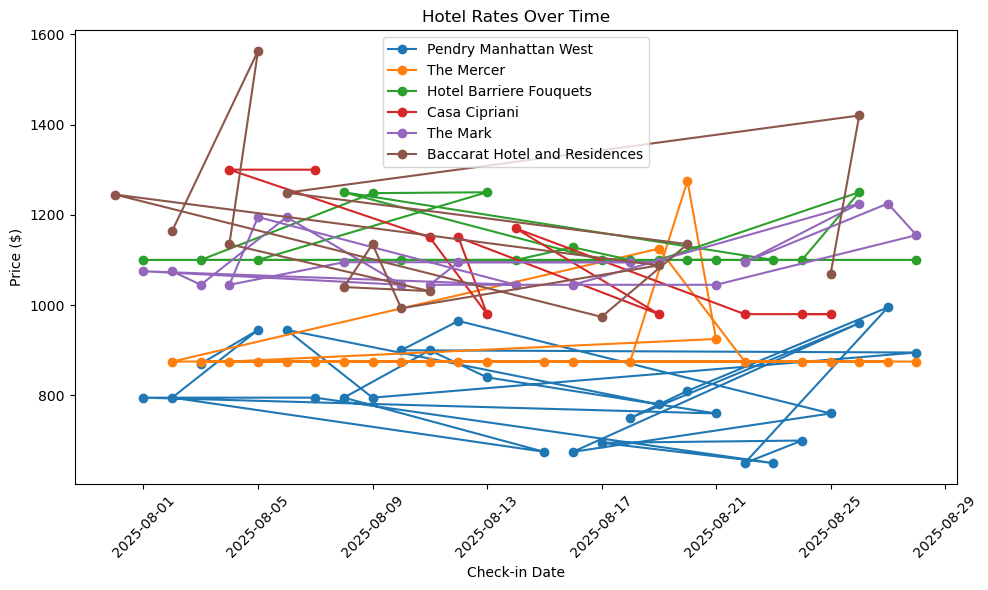

In [14]:
# Cell 13: Analyze Results (Enhanced)
# Let's visualize what we collected
if 'results' in globals() and results and len(results) > 0:
    df = pd.DataFrame(results)
    
    print(f"📊 Analysis of {len(df)} scraping results\n")
    
    # Show availability summary
    available_count = df['is_available'].sum()
    print(f"Available rates: {available_count} out of {len(df)} ({available_count/len(df)*100:.1f}%)")
    
    # Create a pivot table to see prices by hotel and date
    if df['price'].notna().any():
        # Ensure we have only one price per hotel/date (the lowest)
        df_clean = df.groupby(['hotel_name', 'check_in_date']).agg({
            'price': 'min',
            'is_available': 'first'
        }).reset_index()
        
        pivot = df_clean.pivot_table(
            values='price', 
            index='hotel_name', 
            columns='check_in_date', 
            aggfunc='first'
        )
        
        print("\n💰 Price Matrix (Hotel x Date):")
        display(pivot)
        
        # Quick visualization
        import matplotlib.pyplot as plt
        
        # Plot prices over time for each hotel
        plt.figure(figsize=(12, 8))
        
        for hotel in df_clean['hotel_name'].unique():
            hotel_data = df_clean[df_clean['hotel_name'] == hotel]
            available_data = hotel_data[hotel_data['price'].notna()]
            
            if not available_data.empty:
                # Sort by date for smooth line
                available_data = available_data.sort_values('check_in_date')
                
                plt.plot(
                    pd.to_datetime(available_data['check_in_date']), 
                    available_data['price'], 
                    marker='o', 
                    label=hotel,
                    linewidth=2,
                    markersize=6
                )
        
        plt.xlabel('Check-in Date')
        plt.ylabel('Price ($)')
        plt.title('Hotel Rates Over Time (Lowest Fully Refundable Rate per Day)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Set y-axis to start at 0 for better comparison
        plt.ylim(bottom=0)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\n❌ No price data available to visualize")
        print("This is expected if all dates are within 72-hour booking window")
        
        # Show availability by date
        availability_by_date = df.groupby('check_in_date')['is_available'].sum()
        print(f"\nAvailability by date:")
        print(availability_by_date)
else:
    print("❌ No results found. Please run the scraping cells first.")